# SIR modelling - finding age group parameters

## Install packages

In [8]:
import subprocess
import sys

def install(package):
    subprocess.call([
        sys.executable, "-m", "pip", "-q", "install", package
    ])

install('gspread')
install('oauth2client')

## Define global helper functions

In [1]:
# Title, color, vaccination percentage, population count
titles = [
    ['Whole population', '#FFFF00', 0.755, 5822763],
    ['0 - 9', '#228b22', 0, 614489],
    ['10 - 19', '#ffdab9', 0.595, 681911],
    ['20 - 29', '#00008b', 0.74, 782701],
    ['30 - 39', '#b03060', 0.76, 686808],
    ['40 - 49', '#ff0000', 0.87, 756048],
    ['50 - 59', '#ffa500', 0.916, 800444],
    ['60 - 69', '#00ff00', 0.95, 663646],
    ['70 - 79', '#00ffff', 0.96, 564390],
    ['80 - 89', '#ff00ff', 0.965, 227298],
    ['90+', '#1e90ff', 0.95, 45027]
]

def convert_to_int(list):
    return [int(item) for item in list]

def get_age_group_title(age_group_index):
    return titles[age_group_index][0]

def get_age_group_color(age_group_index):
    return titles[age_group_index][1]

def get_age_group_vac_per(age_group_index):
    return titles[age_group_index][2]

def get_age_group_population(age_group_index):
    return titles[age_group_index][3]
    

## Pull Covid-19 data from an excel spreadsheet

### Inspired by:
#### [https://www.twilio.com/blog/2017/02/an-easy-way-to-read-and-write-to-a-google-spreadsheet-in-python.html](https://www.twilio.com/blog/2017/02/an-easy-way-to-read-and-write-to-a-google-spreadsheet-in-python.html)
#### and
#### [https://code.sololearn.com/c4gmt97Se5f9/?ref=app](https://code.sololearn.com/c4gmt97Se5f9/?ref=app)

## Graph parameters for all age groups

<IPython.core.display.Javascript object>


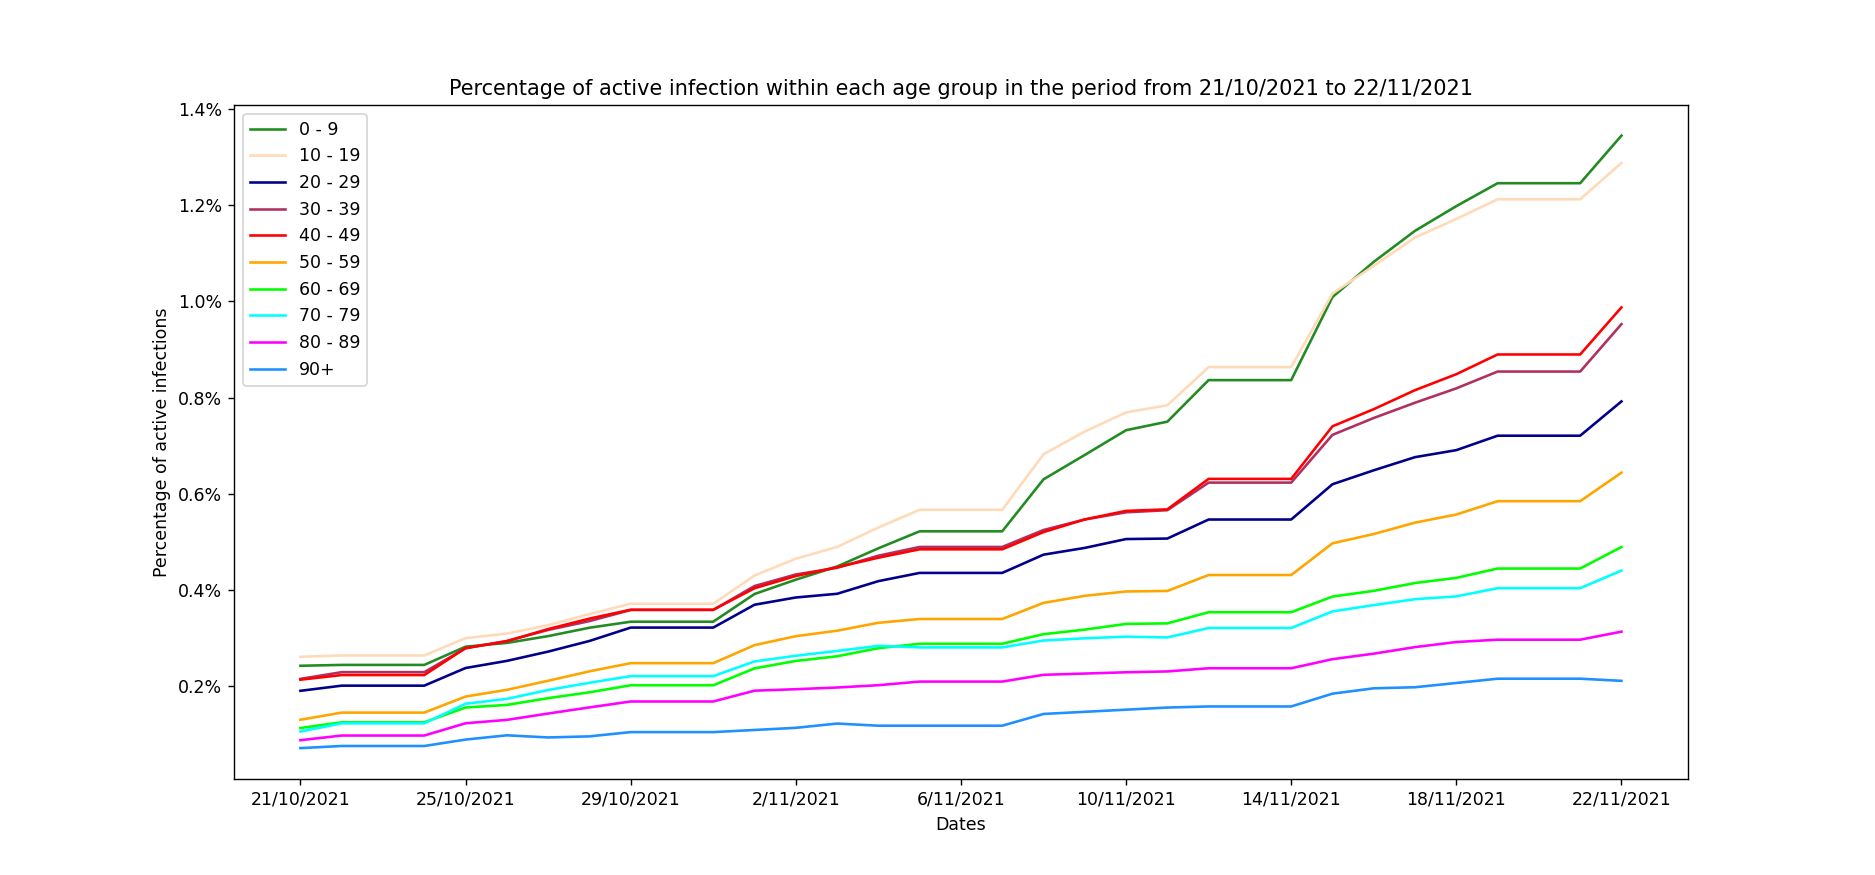

In [31]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/spreadsheets',
         'https://www.googleapis.com/auth/drive.file','https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)

client = gspread.authorize(creds)

import os
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

interval_length = 7

start_date = '21/10/2021'
end_date = '22/11/2021'

plt.figure(figsize = (15, 7)) # 15, 7 | 9, 15

plt.title('Percentage of active infection within each age group in the period from 21/10/2021 to 22/11/2021')
# plt.title('Beta values in intervals of ' + str(interval_length) + ' days in the period from ' + start_date + ' to ' + end_date)

for age_group_index in range(10): #11
    age_group_index = age_group_index + 1
    sheet = client.open('Denmark Covid-19 Data').get_worksheet(age_group_index)
    
    # Modify excel data
    date_full_column = sheet.col_values(1)   # Column A
#     s_full_column = sheet.col_values(2)      # Column B
    i_full_column = sheet.col_values(3)      # Column C
#     r_full_column = sheet.col_values(4)      # Column D

    # Remove first line of each column
    date_full_column.pop(0)
#     s_full_column.pop(0)
    i_full_column.pop(0)
#     r_full_column.pop(0)

    start_index = date_full_column.index(start_date)
    end_index = date_full_column.index(end_date)
    
    date_column = date_full_column[start_index : end_index + 1]
    i_column = convert_to_int(i_full_column[start_index : end_index + 1])

#     First two waves
#     s_column = convert_to_int(s_full_column[start_index : end_index + 1])
#     First two waves
#     r_column = convert_to_int(r_full_column[start_index : end_index + 1])
    
    
    x_axis = [date_column[index] for index in range(len(date_column)) if index % 4 == 0]
    x_axis.pop(len(x_axis) - 1)
    x_axis.append('22/11/2021')
#     print(len(date_column))
#     print(date_column)
    

#     First two waves
#     N = int(s_full_column[0]) + int(i_full_column[0]) + int(r_full_column[0])

#     Third wave
    N = get_age_group_population(age_group_index)
    
#     Third wave
    SSI_vaccinated = N * get_age_group_vac_per(age_group_index)
    
    # Finding beta
    interval_count = math.ceil(len(date_column) / interval_length)

    measure_list = []
    date_list = []

    for interval_index in range(interval_count):
        interval_start_index = interval_index * interval_length
        interval_end_index =  interval_start_index + interval_length

        interval_date_column = date_column[interval_start_index : interval_end_index]
#         interval_s_column = convert_to_int(s_column[interval_start_index : interval_end_index])
        interval_i_column = convert_to_int(i_column[interval_start_index : interval_end_index])
#         interval_r_column = convert_to_int(r_column[interval_start_index : interval_end_index])

        real_interval_length = len(interval_date_column)

        interval_x = np.array(range(real_interval_length))
        interval_y = np.log(interval_i_column)

        p = np.polyfit(interval_x, interval_y, 1)

        m = p[0]  # Slope
        b = p[1]  # Intersection at x = 0

        alpha = 1 / 14

#         Third wave
        S = N - SSI_vaccinated - interval_i_column[0]
    
        beta = (N / S) * (alpha + m)
        Re = (S / N) * (beta / alpha)

#         First two waves
#         beta = (N / interval_s_column[0]) * (alpha + m)
#         Re = (interval_s_column[0] / N) * (beta / alpha)

        measure_list.append(beta)
        date_list.append(interval_date_column[0])

#     x = np.array(range(len(r0_list)))

#     plt.plot(date_list, measure_list, ':o', label = get_age_group_title(age_group_index), color = get_age_group_color(age_group_index))


    i_column = [((value / titles[age_group_index][3]) * 100) for value in i_column]
    plt.plot(date_column, i_column, '-', label = get_age_group_title(age_group_index), color = get_age_group_color(age_group_index))
    
    plt.xticks(x_axis)

plt.legend()

from matplotlib.ticker import FuncFormatter

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.1f}%".format(y)))

plt.xlabel('Dates')
plt.ylabel('Percentage of active infections')

if not os.path.exists('./Images'):
    os.makedirs('./Images')

plt.savefig('./Images/beta_alpha.png')
plt.show()